In [ ]:
# TODO: Add imports

In [ ]:
from matplotlib import colormaps

In [ ]:
colormaps["viridis"](0.5)

(0.127568, 0.566949, 0.550556, 1.0)

Text(0.5, 1.0, 'Covariance matrix')

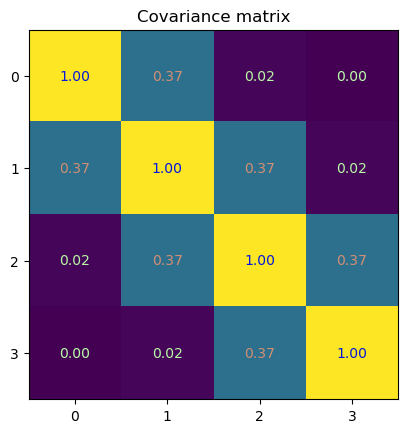

In [ ]:
indices = np.arange(4)
cov = np.exp(- (indices - indices[:, None])**2)

cmap = colormaps["viridis"]

fig, ax = plt.subplots()
im = ax.imshow(cov, cmap=cmap)
for i in indices:
    for j in indices:
        z = cov[i, j]
        c = [1 - x for x in cmap(z)[:-1]]  # invert color
        ax.text(i, j, f"{z:.2f}", c=c, horizontalalignment="center", verticalalignment="center")

ax.xaxis.get_major_locator().set_params(integer=True)
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Covariance matrix")

In [ ]:
tril = np.linalg.cholesky(cov)
assert np.isclose(cov, tril @ tril.T).all()

In [ ]:
u = 10.0
scale_tril = tril * u**-0.5
assert np.isclose(cov/u, scale_tril @ scale_tril.T).all()

In [ ]:
from celestify import PACKAGEDIR
import json, os
import jax.numpy as jnp

In [ ]:
with open(os.path.join(PACKAGEDIR, "data/emulator_error.json"), "r") as file:
    params = json.loads(file.read())

In [ ]:
df = jnp.array(params["df"])
loc = jnp.array(params["mu"])
scale =  jnp.array(np.sqrt(params["theta"]))
L_omega = jnp.array(params["L_omega"])

In [ ]:
scale_tril = scale[:, None] * L_omega

In [ ]:
a = np.stack([[0.0, 1.0, 0.0, 0.0], 
              [0.0, 4.0, 2.0, 0.0]]) * np.log(10.0)
a

array([[0.        , 2.30258509, 0.        , 0.        ],
       [0.        , 9.21034037, 4.60517019, 0.        ]])

In [ ]:
transformed_scale_tril = (a @ scale_tril)
cov = (transformed_scale_tril @ transformed_scale_tril.T)
cov

Array([[4.57671024e-06, 1.20219811e-05],
       [1.20219811e-05, 7.06755314e-05]], dtype=float64)

In [ ]:
mu = np.log([5777., 1.0]) * np.ones((10, 2))

In [ ]:
indices = jnp.arange(2)

def mean_and_cov(mu):
    def unlog_mu(i):
        return jnp.exp(mu[i] + 0.5 * cov[i, i])

    def unlog_cov(i, j):
        return jnp.exp(mu[..., i] + mu[..., j] + 0.5 * (cov[i, i] + cov[j, j])) * (jnp.exp(cov[i, j]) - 1)
    return unlog_mu(indices), unlog_cov(indices, indices[:, None])

# def unlog_cov(i, j):
#     return 10**(mu[i] + mu[j] + 0.5 * (cov[i, i] + cov[j, j])) * (10**(cov[i, j]) - 1)

In [ ]:
from jax import vmap

In [ ]:
corr_mu, corr_cov = vmap(mean_and_cov)(mu)

In [ ]:
# new_cov = np.full_like(transformed_cov, np.nan)
# new_cov[0, 0] = np.exp(transformed_cov[0, 0]) * (np.exp(transformed_cov[0, 0]) - 1)
# new_cov[1, 1] = np.exp(transformed_cov[1, 1]) * (np.exp(transformed_cov[1, 1]) - 1)
# new_cov[0, 1] = np.exp(0.5 * (transformed_cov[0, 0] + transformed_cov[1, 1]))  * (np.exp(transformed_cov[0, 1]) - 1)
# new_cov[1, 0] = np.exp(0.5 * (transformed_cov[0, 0] + transformed_cov[1, 1]))  * (np.exp(transformed_cov[1, 0]) - 1)
# new_cov

In [ ]:
def unlog_mu(i):
    return np.exp(mu[i] + 0.5 * cov[i, i])

# def unlog_mu(i):
    # return 10**(mu[i] + 0.5 * cov[i, i])

In [ ]:
a.shape

(2, 4)

In [ ]:
jnp.matmul(a, outputs[..., None]).shape

(10, 2, 1)

In [ ]:
new_mu = unlog_mu(indices)
new_mu

array([46.76328898,  2.71829995])

In [ ]:
import numpyro.distributions as dist

In [ ]:
# shape = (5000,)
# y = dist.MultivariateNormal(new_mu, covariance_matrix=new_cov).sample(rng, sample_shape=shape)
# log_y = dist.MultivariateNormal(0.0, covariance_matrix=transformed_cov).sample(rng, sample_shape=shape)

shape = (10000,)
keys = random.split(rng, 4)
scaled_precision = dist.Gamma(df/2, df/2).sample(keys[0], shape)

obs_scale = jnp.array([25.0, 0.01])

y = dist.MultivariateNormal(new_mu, covariance_matrix=new_cov/scaled_precision[:, None, None] + jnp.diag(obs_scale)**2).sample(keys[1])
# yp = dist.MultivariateNormal(new_mu+mu, scale_tril=new_scale_tril/scaled_precision[:, None, None]**0.5).sample(keys[2])
log_y = dist.MultivariateNormal(0.0, covariance_matrix=cov/scaled_precision[:, None, None] + (jnp.diag(obs_scale)/10**(mu))**2).sample(keys[3])

/home/alex/miniconda3/envs/celestify/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)
/home/alex/miniconda3/envs/celestify/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)


ValueError: It looks like the provided 'range' is not valid or the sample is empty.

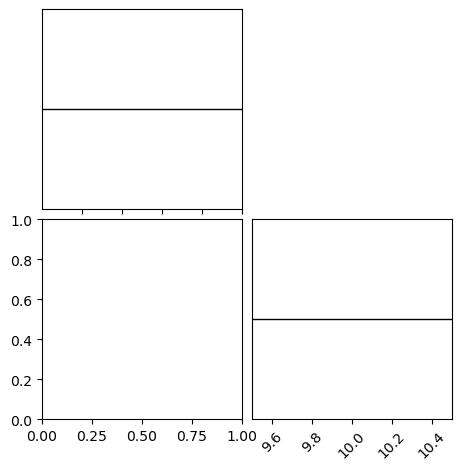

In [ ]:
fig = None
limits = None
limits = [(6700., 7200.), (9.5, 10.5)]
fig = corner(np.array(y), bins=50, density=True, range=limits)
# fig = corner(np.array(yp), fig=fig, color="b", bins=50, density=True, range=limits)
fig = corner(np.power(10, log_y + mu), fig=fig, color="r", bins=50, density=True, range=limits)
# fig = corner(np.power(10, log_y), fig=fig, color="r")

In [ ]:
np.std(y, axis=0)

Array([7.77930460e+01, 1.51442386e-02], dtype=float64)